In [441]:
import pathlib

import gym
import torch
import numpy as np

from matplotlib import pyplot as plt

In [442]:
VIDEO_RECORD_DIR = pathlib.Path("../videos/reinforce/mountain_car")

In [443]:
env = gym.make('MountainCar-v0', new_step_api=True)

In [461]:
class reinforce(torch.nn.Module):

    def __init__(self, policy: torch.nn.Module) -> None:
        super().__init__()
        self.policy = policy
    
    def forward(self, state):
        return self.policy(state)

class ActionReplayBuffer(torch.nn.Module):

    def __init__(self, gamma: float) -> None:
        super().__init__()
        self.gamma = gamma

        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []

    def __len__(self):
        return len(self.state_buffer)
    
    def push(self, state, action, reward):
        self.state_buffer.append(state)
        self.action_buffer.append(action)
        self.reward_buffer.append(reward)
    
    def sample(self):
        self.reward_buffer.reverse()

        for i in range(len(self.reward_buffer) - 1):
            self.reward_buffer[i + 1] = self.reward_buffer[i + 1] + ((self.gamma) * self.reward_buffer[i])

        self.reward_buffer.reverse()

        state_tensor = torch.tensor(self.state_buffer)
        action_tensor = torch.tensor(self.action_buffer)
        reward_tensor = torch.FloatTensor(self.reward_buffer)

        return state_tensor, action_tensor, reward_tensor

    def empty(self):
        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []

def action_multinomial(action_probabilities):
    output = torch.multinomial(action_probabilities, 1)
    return output.item()

def action_soft_multinomial(action_probabilities):
    print(action_probabilities)
    output = torch.multinomial(action_probabilities, 1)
    return output.item()

def reinforce_loss(prob_batch, expected_returns_batch):
    error = torch.log(prob_batch) * expected_returns_batch
    return -torch.mean(error) 


In [462]:
obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n

HIDDEN_SIZE = 256

model = torch.nn.Sequential(
             torch.nn.Linear(obs_size, HIDDEN_SIZE),
             torch.nn.ReLU(),
             torch.nn.Linear(HIDDEN_SIZE, n_actions),
             torch.nn.Softmax(dim=0)
     )

In [463]:
learning_rate = 0.003

MAX_EPISODE_STEPS = 200
MAX_EPISODES = 5000

gamma = 0.9

In [464]:
agent = reinforce(model)
replay_buffer = ActionReplayBuffer(gamma)

optimizer = torch.optim.SGD(agent.parameters(), lr=learning_rate)

In [467]:
def torch_reinforce_train():
    score = []

    for episode in range(MAX_EPISODES + 1):
        state = env.reset()

        ep_score = []
        done = False
    
        for t in range(MAX_EPISODE_STEPS):
            torch_state = torch.from_numpy(state).float()
            action_probs = agent(torch_state)

            action = action_multinomial(action_probs)

            prev_state = state
            step_state = env.step(action)

            state, reward, done = step_state[0], step_state[1], step_state[2]

            reward = reward
            replay_buffer.push(prev_state, action, reward)
            ep_score.append(reward)

            if done:
                break

        score.append(sum(ep_score))

        state_batch, action_batch, reward_batch = replay_buffer.sample()
        replay_buffer.empty()

        reward_batch = reward_batch / torch.abs(reward_batch).max()

        pred_batch = model(state_batch)
        prob_batch = pred_batch.gather(dim=1,index=action_batch
                 .long().view(-1,1)).squeeze()
    
        loss = reinforce_loss(prob_batch, reward_batch) 
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if episode % 50 == 0 and episode > 0:
            print('Trajectory', episode, '\tAverage Score:', np.mean(score[-50:-1]), "\tLoss:", loss.item())
    
    return score    

In [468]:
score = torch_reinforce_train()

Trajectory 50 	Average Score: -200.0 	Loss: -5.059896945953369
Trajectory 100 	Average Score: -200.0 	Loss: -5.0603346824646
Trajectory 150 	Average Score: -200.0 	Loss: -5.059961318969727
Trajectory 200 	Average Score: -200.0 	Loss: -5.059809684753418
Trajectory 250 	Average Score: -200.0 	Loss: -5.059792995452881
Trajectory 300 	Average Score: -200.0 	Loss: -5.0599284172058105
Trajectory 350 	Average Score: -200.0 	Loss: -5.0597429275512695
Trajectory 400 	Average Score: -200.0 	Loss: -5.059720993041992
Trajectory 450 	Average Score: -200.0 	Loss: -5.05844259262085
Trajectory 500 	Average Score: -200.0 	Loss: -5.060192108154297
Trajectory 550 	Average Score: -200.0 	Loss: -5.059793472290039
Trajectory 600 	Average Score: -200.0 	Loss: -5.059593677520752
Trajectory 650 	Average Score: -200.0 	Loss: -5.060055255889893
Trajectory 700 	Average Score: -200.0 	Loss: -5.06041955947876
Trajectory 750 	Average Score: -200.0 	Loss: -5.0594964027404785
Trajectory 800 	Average Score: -200.0 	Los

KeyboardInterrupt: 

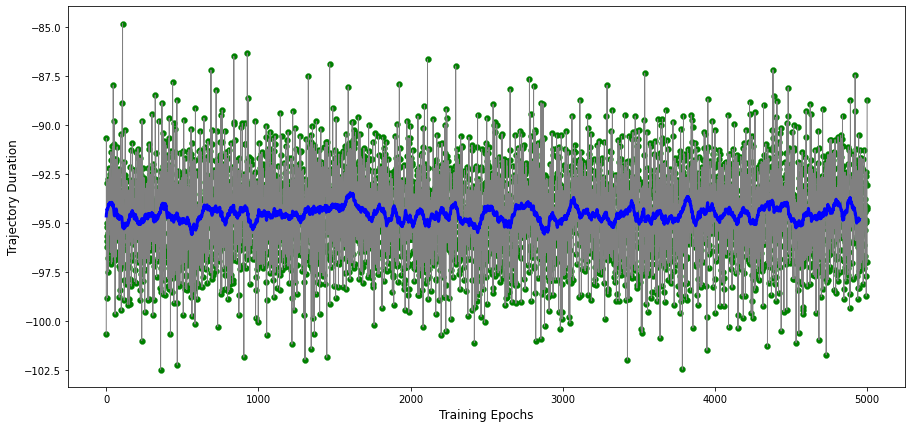

In [438]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

score = np.array(score)
avg_score = running_mean(score)
plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)

In [439]:
from gym.wrappers import RecordVideo

def watch_agent(max_steps=500):
    env = gym.make('MountainCar-v0', new_step_api=True)
    env = RecordVideo(env, video_folder=VIDEO_RECORD_DIR)
    state = env.reset()

    rewards = []

    for t in range(max_steps):
        pred = model(torch.from_numpy(state).float())
        action = torch.argmax(pred).item()

        step_state = env.step(action)
        state, reward, done = step_state[0], step_state[1], step_state[2]

        rewards.append(reward)

        if done:
            print("Reward:", sum([r for r in rewards]))
            break

    env.close()

In [440]:
watch_agent()

/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /Users/lulu/Worskpace/rl-journey/videos/reinforce/mountain_car folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/Users/lulu/Worskpace/rl-journey/.venv/lib/pyth

Reward: -200.0
